In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from ipywidgets import interact
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
from tensorflow.keras.utils import register_keras_serializable

from Training_Data.Particle_Tracking_Training_Data import Particle_Tracking_Training_Data

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


c:\conda\envs\tf\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.2 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "
c:\conda\envs\tf\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.2 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "
c:\conda\envs\tf\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.2 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "
c:\conda\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training_arrays_v1.py:37: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.5)
  from scipy.sparse import issparse  # pylint: disable=g-import-not-at-top
c:\

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_unet_model(input_shape=(256, 256, 1), num_classes=2):
    inputs = tf.keras.Input(shape=input_shape)
    
    # ------------------- Encoder Block 1 -------------------
    # 输出尺寸：256x256 -> 池化后 128x128
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)  # p1: 128x128x64
    
    # ------------------- Encoder Block 2 -------------------
    # 输出尺寸：128x128 -> 池化后 64x64
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)  # p2: 64x64x128
    
    # ------------------- Bridge -------------------
    b = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    b = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(b)  # b: 64x64x256
    
    # ------------------- Decoder -------------------
    # 上采样：将 b 从 64x64 上采样到 128x128
    u1 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(b)  # u1: 128x128x128
    # 拼接：连接 u1 与编码器 Block 2 的输出 c2 (128x128x128)
    concat1 = layers.Concatenate()([u1, c2])  # 结果：128x128x256
    d1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat1)
    d1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(d1)  # d1: 128x128x128
    
    # ------------------- 输出层 -------------------
    # 1×1 卷积，将通道数映射为 num_classes, 使用 softmax 得到每个像素的类别概率
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(d1)  # 输出：128x128x2
    
    model = models.Model(inputs=inputs, outputs=outputs, name="U-Net_256_to_128")
    return model


In [12]:
Nt = 100 ## number of frames for each video
kappa = 0.1 ## standard deviation of background noise added to image
a = 3. ## scale factor for the size of particle spots (not true size of particles)
IbackLevel = 0.15 ## relative intensity of randomly generated background pattern; in (0, 1)
Nparticles = 10 ## the number of particles (more => slower)
sigma_motion = 2.3 ## the standard deviation for particle brownian motion; should be in (0, 10)

## you might consider randomizing some of these parameters when training a neural net

pt = Particle_Tracking_Training_Data(Nt) ## create object instance
## you can 'call' the object as many times as you want
## in this example, we only generate one training example
vid, labels, tracks = pt(kappa, a, IbackLevel, Nparticles, sigma_motion)

# 创建并查看模型结构
model = build_unet_model()
model.summary()

# 2. 生成一个随机输入 (batch_size=1, 256×256, 通道数=1)
frame_0 = tf.expand_dims(tf.expand_dims(vid[0], axis=0), axis=-1)
y1 = model(frame_0)
print("输入形状:", frame_0.shape)
print("输出形状:", y1.shape)

Model: "U-Net_256_to_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_77 (Conv2D)             (None, 256, 256, 64  640         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_78 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_77[0][0]']              
                                )                                                  

In [14]:
X_curr = []
X_prev = []
Y_labels = []

for i in range(1, Nt):
    # 当前帧 shape (256,256,1)
    curr = tf.expand_dims(vid[i],   axis=-1)
    # 前一帧 shape (256,256,1)
    prev = tf.expand_dims(vid[i-1], axis=-1)

    X_curr.append(curr)
    X_prev.append(prev)

    Y_labels.append(labels[i])  # 对应当前帧的标签

X_curr = tf.stack(X_curr, axis=0)  # (Nt-1, 256,256,1)
X_prev = tf.stack(X_prev, axis=0)  # (Nt-1, 256,256,1)
Y_labels = tf.stack(Y_labels, axis=0)

In [3]:
class OneHotMeanIoU(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='mean_iou', **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        # total_confusion_matrix 的形状为 [num_classes, num_classes]
        self.total_cm = self.add_weight(
            name='total_confusion_matrix',
            shape=(num_classes, num_classes),
            initializer='zeros',  # 或 tf.zeros_initializer()
            dtype=tf.float32
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        y_true, y_pred: (batch, height, width, num_classes) 的 one-hot。
        这里先将 one-hot 转成整型类别索引，再更新混淆矩阵。
        """
        y_true_argmax = tf.argmax(y_true, axis=-1)
        y_pred_argmax = tf.argmax(y_pred, axis=-1)

        y_true_argmax = tf.reshape(y_true_argmax, [-1])
        y_pred_argmax = tf.reshape(y_pred_argmax, [-1])

        current_cm = tf.math.confusion_matrix(
            y_true_argmax,
            y_pred_argmax,
            num_classes=self.num_classes,
            weights=sample_weight,
            dtype=tf.float32
        )
        self.total_cm.assign_add(current_cm)

    def result(self):
        # mean IoU = average over (true_positives / union)
        sum_over_row = tf.reduce_sum(self.total_cm, axis=0)
        sum_over_col = tf.reduce_sum(self.total_cm, axis=1)
        true_positives = tf.linalg.diag_part(self.total_cm)
        denominator = sum_over_row + sum_over_col - true_positives
        iou = true_positives / denominator
        return tf.reduce_mean(iou)

    def reset_states(self):
        # 每个 epoch 前自动重置
        tf.keras.backend.batch_set_value(
            [(v, tf.zeros_like(v)) for v in self.variables]
        )


In [4]:
# Define loss function
from tensorflow.keras.utils import register_keras_serializable
@register_keras_serializable()
def weighted_binary_crossentropy(y_true, y_pred):
    """
    Weighted binary crossentropy loss, where the weight for class 1 (particles)
    is 300 times the weight for class 0 (background).
    """
    # Define weight
    weight_for_0 = 1.0 
    weight_for_1 = 100.0 
    
    # Compute weight tensor, with the same shape as y_true
    weights = tf.where(tf.equal(y_true[..., 1], 1), weight_for_1, weight_for_0)
    
    # Calculate binary crossentropy loss
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    
    # Apply weights
    weighted_bce = weights * bce
    
    # Return the mean of the weighted loss
    return tf.reduce_mean(weighted_bce)

In [16]:
# 3. 编译模型
model.compile(
    optimizer='adam',
    loss=weighted_binary_crossentropy,
    metrics=[
        'accuracy',
        OneHotMeanIoU(num_classes=2)  # 二分类示例
    ]
)

In [17]:
from tensorflow.keras.utils import Sequence


class MyDataGenerator(Sequence):
    def __init__(self, pt_instance, batch_size, steps_per_epoch):
        """
        pt_instance: 一个你用来生成合成数据的实例，比如 Particle_Tracking_Training_Data(Nt)
        batch_size: 每个batch的大小
        steps_per_epoch: 每个epoch的 batch 数量
        """
        self.pt = pt_instance
        self.batch_size = batch_size
        self.steps_per_epoch = steps_per_epoch

        # 第一次生成数据
        self.on_epoch_end()

    def __len__(self):
        # 每次 epoch 中的 batch 数量
        return self.steps_per_epoch

    def __getitem__(self, index):
        # 从 self.X_curr, self.X_prev, self.Y_labels 中取出第 index 个 batch
        start_i = index * self.batch_size
        end_i = start_i + self.batch_size

        batch_X_curr = self.X_curr[start_i:end_i]
        batch_Y = self.Y_labels[start_i:end_i]

        return (batch_X_curr, batch_Y)

    def on_epoch_end(self):
        """
        每个 epoch 结束后自动调用
        - 在这里可以重新生成一整套 (Nt-1) 帧的合成数据，
          或者打乱已有数据的顺序
        """
        # 例如，每次都重新生成 Nt 帧
        # 这里演示：Nt=100
        Nt = 100 ## number of frames for each video
        kappa = 0.1 ## standard deviation of background noise added to image
        a = 3 ## scale factor for the size of particle spots (not true size of particles)
        IbackLevel = 0.15 ## relative intensity of randomly generated background pattern; in (0, 1)
        Nparticles = 10 ## the number of particles (more => slower)
        sigma_motion = 2.3 ## the standard deviation for particle brownian motion; should be in (0, 10)

        # 假设你调用 pt(...) 来生成数据
        vid, labels, tracks = self.pt(kappa, a, IbackLevel, Nparticles, sigma_motion)   # 根据需要传参

        # 再把 vid/labels 构造成 X_curr, X_prev, Y_labels
        # (Nt-1, 256,256,1) ...
        X_curr = []
        Y_labels = []
        for i in range(1, Nt):
            curr = np.expand_dims(vid[i],   axis=-1)  # (256,256,1)
            X_curr.append(curr)
            # 假设 labels[i] is (128,128,2)
            Y_labels.append(labels[i])

        # 转为 numpy array => (Nt-1, 256,256,1) ...
        self.X_curr = np.stack(X_curr, axis=0)
        self.Y_labels = np.stack(Y_labels, axis=0)

        # 这里可以再打乱
        idx = np.arange(self.X_curr.shape[0])
        np.random.shuffle(idx)
        self.X_curr = self.X_curr[idx]
        self.Y_labels = self.Y_labels[idx]

# 使用
batch_size = 4
steps_per_epoch = 25  # 假设 (Nt-1)=99, 99/4≈25
pt_instance = Particle_Tracking_Training_Data(Nt=100)  # 你的数据生成类

train_gen = MyDataGenerator(pt_instance, batch_size=batch_size, steps_per_epoch=steps_per_epoch)

history = model.fit(
    train_gen,
    epochs=20
)

Epoch 1/20
25/25 [==============================] - 24s 939ms/step - loss: 76.5542 - accuracy: 0.9440 - mean_iou: 0.4935
Epoch 2/20


c:\conda\envs\tf\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric OneHotMeanIoU implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


25/25 [==============================] - 35s 1s/step - loss: 0.1626 - accuracy: 0.9840 - mean_iou: 0.5867
Epoch 3/20
25/25 [==============================] - 50s 2s/step - loss: 0.1346 - accuracy: 0.9897 - mean_iou: 0.6265
Epoch 4/20
25/25 [==============================] - 56s 2s/step - loss: 0.0953 - accuracy: 0.9931 - mean_iou: 0.6623
Epoch 5/20
25/25 [==============================] - 50s 2s/step - loss: 0.1154 - accuracy: 0.9835 - mean_iou: 0.5884
Epoch 6/20
25/25 [==============================] - 52s 2s/step - loss: 0.0798 - accuracy: 0.9898 - mean_iou: 0.6299
Epoch 7/20
25/25 [==============================] - 54s 2s/step - loss: 0.0573 - accuracy: 0.9905 - mean_iou: 0.6352
Epoch 8/20
25/25 [==============================] - 46s 2s/step - loss: 0.0376 - accuracy: 0.9949 - mean_iou: 0.7174
Epoch 9/20
25/25 [==============================] - 29s 1s/step - loss: 0.0502 - accuracy: 0.9922 - mean_iou: 0.6536
Epoch 10/20
25/25 [==============================] - 30s 1s/step - loss: 0.

In [18]:
Nt = 100 ## number of frames for each video
kappa = 0.1 ## standard deviation of background noise added to image
a = 3. ## scale factor for the size of particle spots (not true size of particles)
IbackLevel = 0.15 ## relative intensity of randomly generated background pattern; in (0, 1)
Nparticles = 10 ## the number of particles (more => slower)
sigma_motion = 2.3 ## the standard deviation for particle brownian motion; should be in (0, 10)

## you might consider randomizing some of these parameters when training a neural net

pt = Particle_Tracking_Training_Data(Nt) ## create object instance
## you can 'call' the object as many times as you want
## in this example, we only generate one training example
vid, labels, tracks = pt(kappa, a, IbackLevel, Nparticles, sigma_motion) 

x_test = []
x_p = []
y_test = []

for i in range(0, Nt):
    # 当前帧 shape (256,256,1)
    curr = tf.expand_dims(vid[i],   axis=-1)
    pre = tf.expand_dims(vid[i-1], axis=-1)
    
    x_test.append(curr)
    x_p.append(pre)
    
    y_test.append(labels[i])  # 对应当前帧的标签

x_test = tf.stack(x_test, axis=0)  # (Nt-1, 256,256,1)
x_p = tf.stack(x_p, axis=0)  # (Nt-1, 256,256,1)
y_test = tf.stack(y_test, axis=0)

model.evaluate(x_test, y_test, batch_size=32)
predictions = model.predict(x_test)

@interact(t=(0, Nt-2, 1))
def plotfn(t=0, show_tracks=True):
    fig = figure(1, [14, 7])
    fig.add_subplot(131)
    imshow(vid[t], origin='lower')
    if show_tracks:
        plot(tracks[t, :, 0], tracks[t, :, 1], 'rx')
    xlim(-10, 265)
    ylim(-10, 265)

    fig.add_subplot(132)
    imshow(vid[t], origin='lower')
    imshow(labels[t, ..., 1], origin='lower')

    fig.add_subplot(133)
    imshow(vid[t], origin='lower')
    imshow(predictions[t, ..., 1], origin='lower')

4/4 [==============================] - 5s 1s/step


interactive(children=(IntSlider(value=0, description='t', max=98), Checkbox(value=True, description='show_trac…

In [23]:
model.save("unet_model")

INFO:tensorflow:Assets written to: unet_model\assets


INFO:tensorflow:Assets written to: unet_model\assets


In [29]:
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'mean_iou'])


In [30]:
final_train_iou = history.history['mean_iou'][-1]
final_train_accuracy = history.history['accuracy'][-1]
print("Final Training Accuracy:", final_train_accuracy)
print("Final Training Mean IoU:", final_train_iou)

Final Training Accuracy: 0.9935358166694641
Final Training Mean IoU: 0.6775779128074646


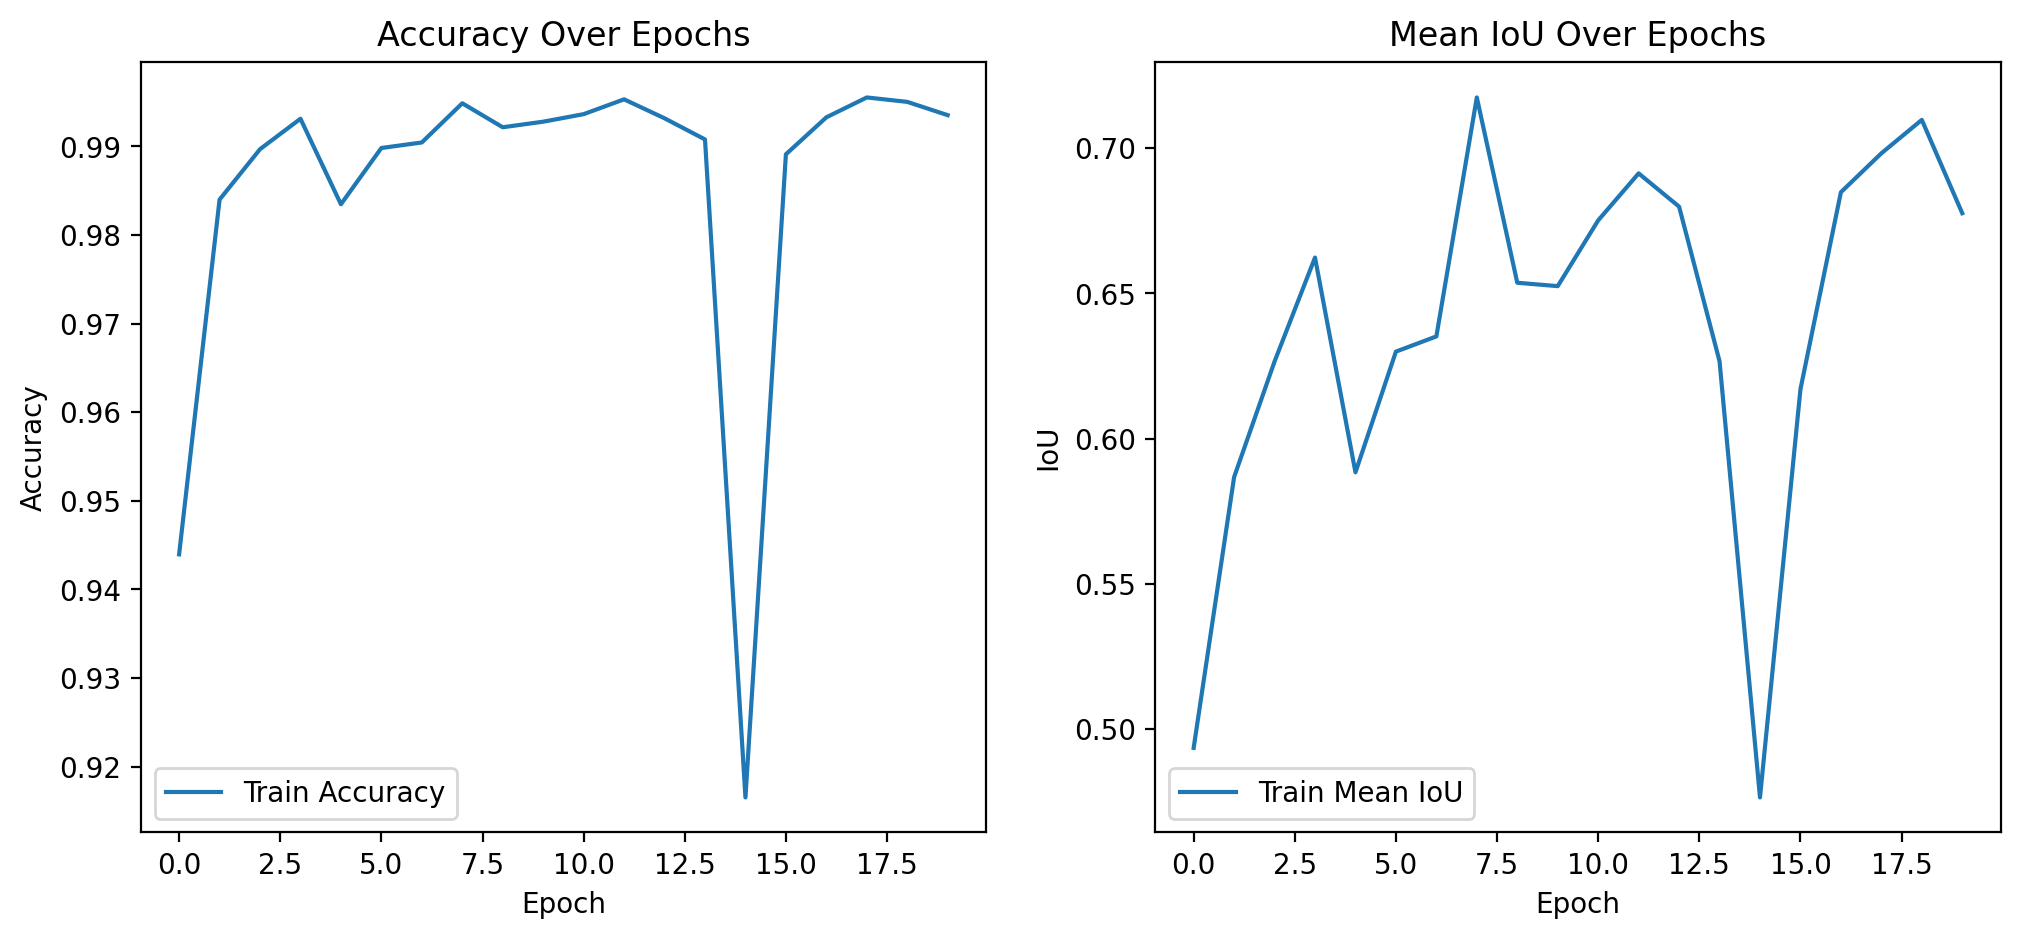

In [35]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mean_iou'], label='Train Mean IoU')
plt.title("Mean IoU Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.legend()

plt.show()


In [5]:
unet = tf.keras.models.load_model("unet_model", custom_objects={'OneHotMeanIoU': lambda **kwargs: OneHotMeanIoU(num_classes=2, **kwargs)})


In [6]:
Nt = 100 ## number of frames for each video
kappa = 0.1 ## standard deviation of background noise added to image
a = 3. ## scale factor for the size of particle spots (not true size of particles)
IbackLevel = 0.15 ## relative intensity of randomly generated background pattern; in (0, 1)
Nparticles = 10 ## the number of particles (more => slower)
sigma_motion = 2.3 ## the standard deviation for particle brownian motion; should be in (0, 10)

## you might consider randomizing some of these parameters when training a neural net

pt = Particle_Tracking_Training_Data(Nt) ## create object instance
## you can 'call' the object as many times as you want
## in this example, we only generate one training example
vid, labels, tracks = pt(kappa, a, IbackLevel, Nparticles, sigma_motion) 

x_test = []
x_p = []
y_test = []

for i in range(0, Nt):
    # 当前帧 shape (256,256,1)
    curr = tf.expand_dims(vid[i],   axis=-1)
    pre = tf.expand_dims(vid[i-1], axis=-1)
    
    x_test.append(curr)
    x_p.append(pre)
    
    y_test.append(labels[i])  # 对应当前帧的标签

x_test = tf.stack(x_test, axis=0)  # (Nt-1, 256,256,1)
x_p = tf.stack(x_p, axis=0)  # (Nt-1, 256,256,1)
y_test = tf.stack(y_test, axis=0)

unet.evaluate([x_test, x_p], y_test, batch_size=32)

predictions = unet.predict([x_test, x_p])

@interact(t=(0, Nt-2, 1))
def plotfn(t=0, show_tracks=True):
    fig = figure(1, [14, 7])
    fig.add_subplot(131)
    imshow(vid[t], origin='lower')
    if show_tracks:
        plot(tracks[t, :, 0], tracks[t, :, 1], 'rx')
    xlim(-10, 265)
    ylim(-10, 265)

    fig.add_subplot(132)
    imshow(vid[t], origin='lower')
    imshow(labels[t, ..., 1], origin='lower')

    fig.add_subplot(133)
    imshow(vid[t], origin='lower')
    imshow(predictions[t, ..., 1], origin='lower')

c:\conda\envs\tf\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric OneHotMeanIoU implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


ValueError: in user code:

    File "c:\conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1727, in test_function  *
        return step_function(self, iterator)
    File "c:\conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1713, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1701, in run_step  **
        outputs = model.test_step(data)
    File "c:\conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1665, in test_step
        y_pred = self(x, training=False)
    File "c:\conda\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\conda\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "U-Net_256_to_128" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 256, 256, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 256, 256, 1) dtype=float32>]
